## Simulación de medición y análisis de datos

In [43]:
#Importo librerías
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad

#Defino ctes
pi = math.pi

In [44]:
#Defino tiempo inicial y tiempo final
t_ini = 0
t_fin = 8

In [58]:
def S_A(t, t0, sigma, w):
    '''
    Señal modelo sin normalizar
    '''
    
    return np.exp( -(t-t0)**2/(2*sigma**2) )*np.cos(w*(t-t0+sigma))


def cte_A(t0, sigma, w):
    '''
    Calcula la cte de normalización A de la señal modelo de modo que el área debajo de la curva sea 1

    '''
    def S_A_reduced(t):
        return S_A(t,t0,sigma,w)

    area = quad(S_A_reduced, -t_fin,6*t_fin, epsabs = 1e-25, epsrel = 1e-25, limit = 1000)
    print(area)
    A = 1/area[0]
    return A

def S(t, A, t0, sigma, w):
    '''
    Señal modelo producida por el detector a tiempo t con centro t0, ancho sigma y frecuenca omega

    Paramaters
    ----------
    t (float): tiempo
    t0 (float): centro
    sigma (float): ancho
    w(float): frecuencia de oscilación

    Returns
    -------
    float: señal a tiempo t
    
    Nota:
    (1) La constante A es tal que la integral del pulso es igual a 1. Para calcular la integral se emplean cuadrados mínimos
    (2) El tiempo t puede ser un ndarray
    '''
    return A*S_A(t, t0, sigma, w)


(-1.0136889502607751e-44, 1.8908246554346323e-44)


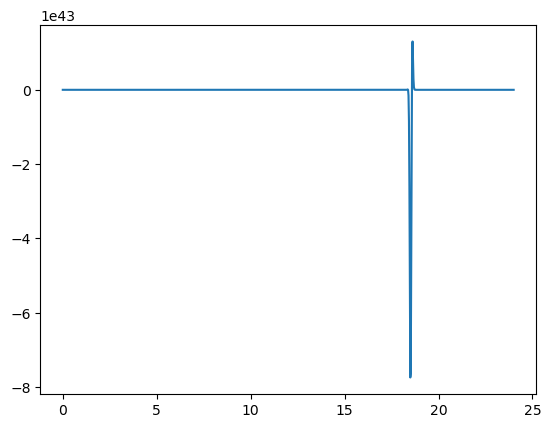

In [46]:
#Grafico S para t0 = 0.5, sigma = 0.1 y w = 0.1 y comparo con el gráfico del enunciado

M = 1000 #nro de puntos
t_array = np.linspace(t_ini,3*t_fin, M)
S_array = np.zeros(M)
# t0 = 1.8
# sigma = 0.05
# w = 5*pi

t0, sigma, w = 18.530683598825483, 0.05129031348529752, 15.667834508710843

A = cte_A(t0,sigma,w)

for i in range(M):
    S_array[i] = S(t_array[i],A,t0,sigma,w)
    # S_array[i] = S_A(t_array[i],t0,sigma,w)
plt.plot(t_array, S_array)
# plt.ylim([0,1e5])


In [47]:
import scipy
scipy.integrate.simps(S_array,t_array)

-6.374125800244853e+42

In [48]:
from scipy.stats import betaprime, norm

In [49]:
# betaprime.rvs(a = 4, b = 2, loc = 1.8, size = 10)

In [50]:
#Distribuciones
# def A_dist():

#     A0 = 10
#     sigma_A = 1
#     return norm.rvs(loc = A0, scale = sigma_A)

def t0_dist(t0):
    '''
    Posición de cada pico determinada por la distribución Beta prime centrada en t0 con parámetros a = 4 y b = 2
    
    Parameters
    ----------
    t0 (float): centro de la distribución

    Returns
    -------
    float: posición del pico
    '''
    a = 4
    b = 2
    return betaprime.rvs(a = a, b = b, scale = t0)

def sigma_dist():
    '''
    Ancho sigma del pico central determinado por la distribución normal con valor medio sigma0 = 0.05 y desviación sigma_sigma = 0.005
    
    Parameters
    ----------
    None

    Returns
    -------
    float: ancho sigma
    '''
    sigma0 = 0.05
    sigma_sigma = 0.005
    return norm.rvs(loc = sigma0, scale = sigma_sigma)

def w_dist():
    '''
    Frecuencia de oscilación w determinada por la distribución normal con valor medio w0 = 5 pi y desviación sigma_w = 0.05
    
    Parameters
    ----------
    None

    Returns
    -------
    float: ancho sigma
    '''
    w0 = 5*pi
    sigma_w = 0.05

    return norm.rvs(loc = w0, scale = sigma_w)

def ruido_dist(señal):
    '''
    Señal de ruido a tiempo t. Está conformada por 2 componentes
    (1) Ruido relativo: dado por una distribución normal con valor medio 1 y ancho 0.1. Este se multiplica a la señal
    (2) Ruido absoluto: dado por una distribución normal con valor medio nulo y ancho 0.2. Este se suma a la señal
    El ruido solo afecta a los datos y = y_0*ruido_rel + ruido_abs

    Parameters
    ----------
    señal (float): valor simulado de la señal sin ruido ni fondo lineal

    Returns
    -------
    float: señal ruido

    Nota: puede aceptar ndarray
    '''
    ruido_rel = norm.rvs(loc = 1, scale = 0.1, size = len(señal))*señal
    ruido_abs = norm.rvs(loc = 0, scale = 0.2, size = len(señal))

    return ruido_rel + ruido_abs

def fondo(t):
    '''
    Señal de fondo lineal sobre la que se monta todo el espectro.
    
    Parameters
    ----------
    t (float): tiempo

    Returns
    -------
    float: valor del fondo a tiempo t
    '''
    
    return (-t+2)/100


In [51]:
#Grafico betaprime
T0 = 1.8
rv = betaprime(a = 4, b = 2, scale = T0)
# rv = norm(loc = 1, scale = 1)
t_array = np.linspace(0,8,1000)
beta = rv.pdf(t_array)

1.8018018018018018

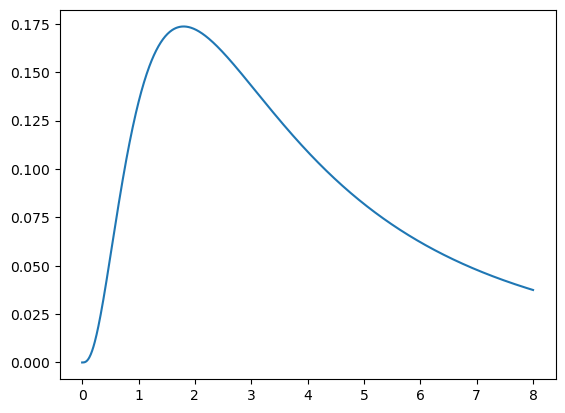

In [52]:
plt.plot(t_array, beta)
np.where(beta==np.max(beta))
t_array[225]

### Ejercicio 1

Una medición puede estar compuesta por cualquiera de las 3 señales, cada una con una probabilidad distinta. En cada medición, la señal i con centro en t0_i tengo que tirar un dado con probabilidad P_i. En caso positivo, tengo que producir una señal S(t,t0_dist(t0), sigma_dist, w_dist)_i. Luego, le sumo el ruido y el fondo.

In [53]:
from scipy.stats import bernoulli

In [54]:
def genero_señal(T0, M):
    '''
    Produzco una señal (un pico) localizado en tiempo T0. No posee ruido ni fondo
    
    Parameters
    ----------
    T0 (float): tiempo en el que se localiza el pico
    N (int): tamaño del ndarray señal


    Returns
    -------
    señal (ndarray): array señal
    '''
    #Verifico que N sea entero TO-DO


    #Defino los parámetros característicos de la señal
    t0 = t0_dist(T0)
    sigma = sigma_dist()
    w = w_dist()

    print(t0, sigma, w)
    
    A = cte_A(t0,sigma,w)
    
    

    #Creo el vector de tiempos
    t_array = np.linspace(t_ini, t_fin, M)

    #Calculo la señal
    señal = S(t_array, A, t0, sigma, w)

    if señal == 0:
        return 0

    return t_array, señal


def medicion(T0_array, P_array, M):
    '''
    Simulo una medición. Para esto es necesario producir 3 señales con centros dados por T0_array y probabilidades de ocurrencia P_array. Luego, es necesario sumar el ruido a la medición y el fondo.

    Parameters
    ----------
    T0_array (ndarray): centros de las señales posibles
    P_array (ndarray): probabilidad de ocurrencia de cada una de las señales posibles. El orden corresponde al dado en T0_array
    M (int): tamaño del ndarray medicion

    Returns
    -------
    medicion (ndarray): medicion simulada
    
    '''
    #Creo el array de mediciones y de tiempos
    medicion = np.zeros(M)
    t_array = np.linspace(t_ini, t_fin, M)

    #Para cada señal posible
    for i in range(len(T0_array)):
        #Tiro un dado con probabilidad P para ver si se observa la señal
        ocurrencia = bernoulli.rvs(P_array[i])
        print(ocurrencia)
        if ocurrencia == True: #ocurre
            t_array, señal = genero_señal(T0_array[i], M)
            medicion += señal
    
    #Sumo ruido
    medicion += ruido_dist(medicion)   

    #Sumo fondo
    medicion += fondo(t_array)

    return t_array, medicion

2.9242506898034097 0.04693460632180434 15.701778221617445
(-1.1096042333246269e-52, 2.088097429759528e-52)


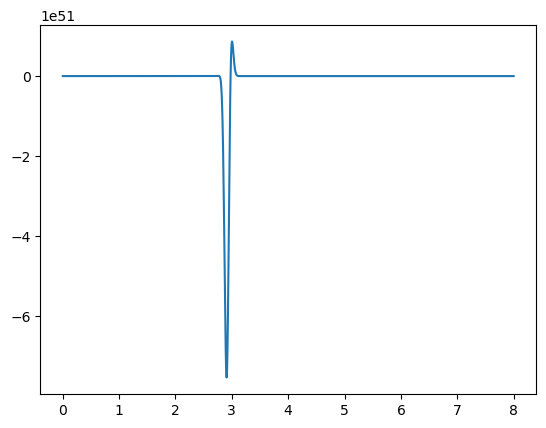

In [55]:
#Grafico una señal
T0 = 1.8
M = 1000
t_array, señal = genero_señal(T0, M)
plt.plot(t_array, señal)


1
3.7742697238408933 0.05309687909400891 15.748854226968831
(-1.7954880238452627e-66, 0.0)
0
0


Text(0.5, 0, '$tiempo \\, (\\mu s)$')

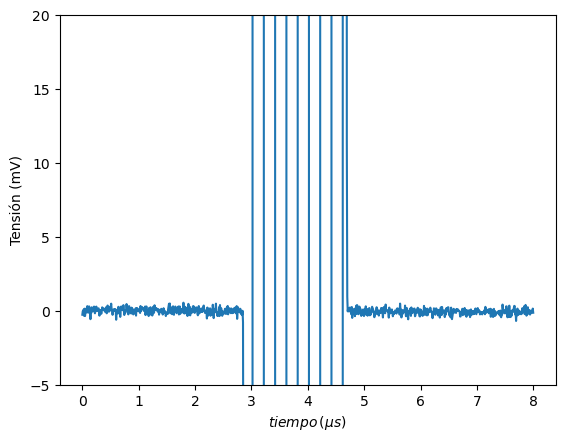

In [56]:
#Grafico una medición
T0_array = np.array([1.8,2.8,5])
P_array = np.array([0.3,0.1,0.6])
t_array, medicion_array = medicion(T0_array, P_array, M)
plt.plot(t_array, medicion_array)
plt.ylim([-5,20])
plt.ylabel("Tensión (mV)")
plt.xlabel("$tiempo \, (\mu s)$")

### Ejercicio 2

In [57]:
def mediciones(N):
    '''
    Resultado de N mediciones. Calculo N mediciones con centros de las señales y probabilidades de ocurrencia determinados.

    Parameters
    ----------
    N (int): nro de mediciones simuladas
    
    '''
    

    pass

def mediciones_mean(N):
    #Genero N mediciones y devuelvo el promedio
    
    

SyntaxError: incomplete input (2065622712.py, line 17)

### Ejercicio 3

### Ejercicio 4